In [ ]:
#### detect hardware
from google.colab import drive
drive.mount('/content/drive/')

#### check for gpu
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    print(local_device_protos)

get_available_gpus()
##################################

Mounted at /content/drive/
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1423271631926061169
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3771646933626716870
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2607389077723628057
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14640891840
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14210646899771169186
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
root = '/content/drive/My Drive/DNAChallenge/'
trainFeatures = root + 'train_values.csv'
trainLabels = root + 'train_labels.csv'
testFeatures =  root + 'test_values.csv'
submission = root + 'submission.csv'

In [ ]:
x_train = pd.read_csv(trainFeatures)
y_train = pd.read_csv(trainLabels)

x_test = pd.read_csv(testFeatures)

In [ ]:
x_train = x_train.set_index('sequence_id').join(y_train.set_index('sequence_id'))

In [ ]:
#ATCG
#1234
def fct(char):
  if char == 'A':
    return 1
  if char == 'T':
    return 2
  if char == 'C':
    return 3
  if char == 'G':
    return 4
  if char == 'N':
    return 5

MAXLEN = 512

val = []

for id, row in x_train.iterrows():
  res = list(map(fct, list(row['sequence'])))
  res = res[0:MAXLEN]

  if len(res) < MAXLEN:
    res += [0] * (MAXLEN-len(res))

  val.append(np.array(res))

In [ ]:
val = np.array(val)
print(val.shape)

(63017, 512)


In [ ]:
target = [x for x in y_train.columns if 'sequence' not in x]

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(val, x_train[target], test_size=0.2)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(50413, 512)
(50413, 1314)
(12604, 512)
(12604, 1314)


In [ ]:
from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy) 

######################## try mixed policy T4
EMBSIZE = 128

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [ ]:
inputs =  tf.keras.layers.Input(shape=(MAXLEN,1))

c = tf.keras.layers.Conv1D(16, 7, padding='same', activation='relu')(inputs)
c = tf.keras.layers.MaxPooling1D(3)(c)
c = tf.keras.layers.ReLU()(c)

d = tf.keras.layers.Conv1D(16, 9, padding='same', activation='relu')(inputs)
d = tf.keras.layers.MaxPooling1D(3)(d)
d = tf.keras.layers.ReLU()(d)

e = tf.keras.layers.Conv1D(16, 11, padding='same', activation='relu')(inputs)
e = tf.keras.layers.MaxPooling1D(3)(e)
e= tf.keras.layers.ReLU()(e)

x = tf.keras.layers.concatenate([c,d,e])
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Flatten()(x)
###Dense layers
x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.ReLU()(x)
### prediction layer
predictions = tf.keras.layers.Dense(1314, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=predictions)

In [ ]:
metric = tf.keras.metrics.TopKCategoricalAccuracy(k=10)

In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(1e-02), metrics=['categorical_accuracy', metric])

In [ ]:
model.summary()

Model: "functional_59"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 512, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_148 (Conv1D)             (None, 512, 16)      128         input_31[0][0]                   
__________________________________________________________________________________________________
conv1d_149 (Conv1D)             (None, 512, 16)      160         input_31[0][0]                   
__________________________________________________________________________________________________
conv1d_150 (Conv1D)             (None, 512, 16)      192         input_31[0][0]                   
______________________________________________________________________________________

In [ ]:
!pip install keras-lr-finder

Epoch 1/5
99/99 [==============================] - 3s 29ms/step - loss: 5.3872 - categorical_accuracy: 0.2332 - top_k_categorical_accuracy: 0.3711
Epoch 2/5
99/99 [==============================] - 3s 29ms/step - loss: 3.2700 - categorical_accuracy: 0.4515 - top_k_categorical_accuracy: 0.6680
Epoch 3/5
99/99 [==============================] - 3s 29ms/step - loss: 2.7980 - categorical_accuracy: 0.5427 - top_k_categorical_accuracy: 0.7617
Epoch 4/5
99/99 [==============================] - 3s 28ms/step - loss: 67.1221 - categorical_accuracy: 0.2781 - top_k_categorical_accuracy: 0.6894


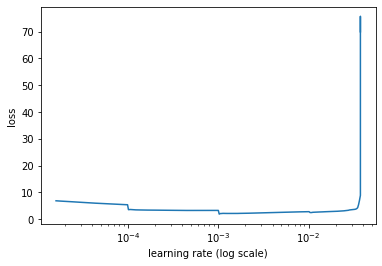

In [ ]:
from keras_lr_finder import LRFinder

lr_finder = LRFinder(model)

lr_finder.find(x_train, y_train, start_lr=0.00001, end_lr=1, batch_size=512, epochs=5)
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)


In [ ]:
history = model.fit(x_train, y_train, epochs=40, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/40
99/99 [==============================] - 3s 35ms/step - loss: 4.8368 - categorical_accuracy: 0.3485 - top_k_categorical_accuracy: 0.5324 - val_loss: 9.9957 - val_categorical_accuracy: 0.2153 - val_top_k_categorical_accuracy: 0.3674
Epoch 2/40
99/99 [==============================] - 3s 31ms/step - loss: 2.9278 - categorical_accuracy: 0.4820 - top_k_categorical_accuracy: 0.7023 - val_loss: 4.8756 - val_categorical_accuracy: 0.3445 - val_top_k_categorical_accuracy: 0.5759
Epoch 3/40
99/99 [==============================] - 3s 31ms/step - loss: 2.0085 - categorical_accuracy: 0.5906 - top_k_categorical_accuracy: 0.8209 - val_loss: 4.2213 - val_categorical_accuracy: 0.4125 - val_top_k_categorical_accuracy: 0.6346
Epoch 4/40
99/99 [==============================] - 3s 31ms/step - loss: 1.3991 - categorical_accuracy: 0.6980 - top_k_categorical_accuracy: 0.8962 - val_loss: 4.6200 - val_categorical_accuracy: 0.4468 - val_top_k_categorical_accuracy: 0.6573
Epoch 5/40
99/99 [==========

In [ ]:
#### helper plot function
import matplotlib.pyplot as plt
def plot_acc_loss(history):
  plt.plot(history.history['categorical_accuracy'], label='acc')
  plt.plot(history.history['val_categorical_accuracy'], label='val_acc')
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(loc='upper left')
  plt.show()


  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_los')
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(loc='upper right')
  plt.show()
    
  plt.plot(history.history['top_k_categorical_accuracy'], label='top10')
  plt.plot(history.history['val_top_k_categorical_accuracy'], label='val_top10')
  plt.title('model top10')
  plt.ylabel('top10')
  plt.xlabel('epoch')
  plt.legend(loc='upper right')
  plt.show()

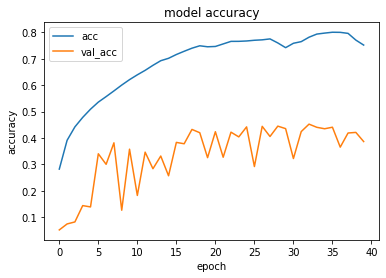

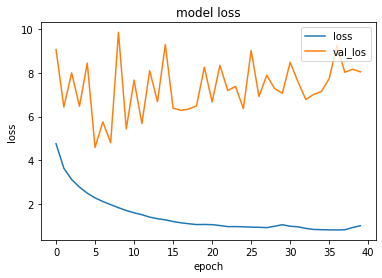

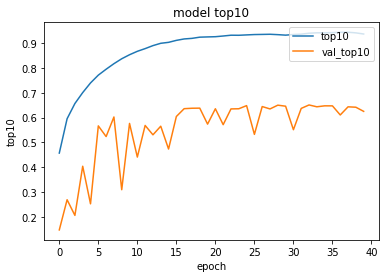

In [ ]:
plot_acc_loss(history)

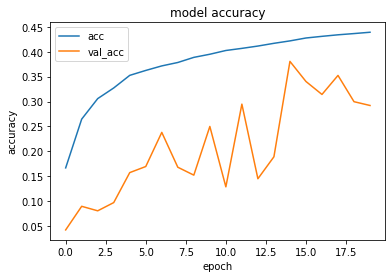

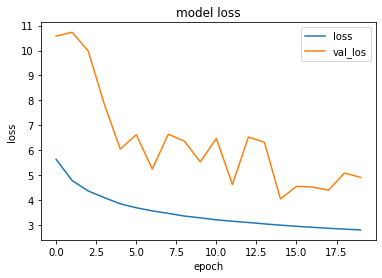

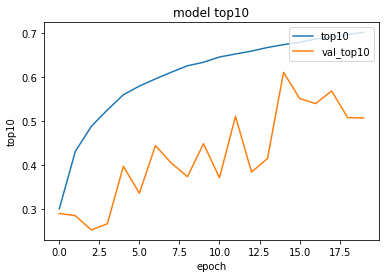

In [ ]:
plot_acc_loss(history)